## Project 1. Nested Monte-Carlo for expected loss


#### $\blacktriangleright$ Setting
We consider a Black-Scholes model at discrete dates $t_i$:

$$
S_{t_i} = S_0 \, e^{\sigma \, W_{t_i} - \frac 12 \sigma^2 t_i},
\qquad t_0 < t_1 < \dots < t_n,
$$

which we use to generate option prices (note we consider zero interest rate $r=0$). 

In particular, the price at time $t_1$ of a Put option with maturity $t_2$ and strike price $K$ is given by 

$$
P(t_1, S_{t_1}) = \mathbb E \bigl[ (K - S_{t_2})^+ \big| S_{t_1} \bigr]
$$

where $x^+$ denotes the positive part of $x$; the explicit Black-Scholes formula is of course available for the function $P(t,S)$

$$
P(t,S) = K \mathcal N \biggl(\frac{\ln \frac K {S}}{\sigma \sqrt{t_2 - t}} + \frac 12 \sigma \sqrt{t_2 - t} \biggr)
- S \, \mathcal N \biggl(\frac{\ln \frac K {S}}{\sigma \sqrt{t_2 - t}} - \frac 12 \sigma \sqrt{t_2 - t} \biggl),
\qquad t \le t_2, \ S > 0
$$

where $\mathcal N$ is the standard gaussian cdf.

We wish to apply Monte-Carlo simulation to the evaluation of the _nested_ expectation

$$
I = \mathbb E \Bigl[\Bigl(P(t_1, S_{t_1}) - P(t_0, S_0) \Bigr)^+ \Bigr]
$$

which represents the _expected loss_ (or exposure) at time $t_1$ of a short position on the put option of maturity $t_2$. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import numpy.linalg as LA

####  1. Benchmark value (semi-explicit in this case)

In the framework of the model above, it is possible to evaluate the nested expectation $I$ using numerical evaluation of a 1D integral with a deterministic quadrature formula, since

$$
I = \int_{\mathbb R} \Bigl(P \bigl(t_1, S_0 \, e^{\sigma \, \sqrt{t_1} \, y \, - \, \frac 12 \sigma^2 t_1} \bigr) - P(t_0, S_0) \Bigr)^+
\frac{e^{-\, y^2/2}}{\sqrt{2 \pi}} \, dy
$$

and the integrand function is explicit.

We can numericall evaluate the integral on the right hand side using the function `scipy.integrate.quad` (we suggest to check out the input and output formats of this function on the online documentation).

We will use this value as a benchmark value for $I$.

We start by initialing the parameters.

In [ ]:
# Option parameters
t_2 = 2 #maturity
K = 100 #strike price
S_0 = 100 #initial stock price

# Model parameter
sigma = 0.3 #volatility

# Intermediate date
t_1 = t_2/2

We now define a function that computes the Black-Scholes price at a given time t for put option with maturity T.

More precisely, we first compute the time difference deltaT between T and t, and then calculate sigmaSqrtDeltaT as the product of the volatility sigma and the square root of deltaT.

Next, we compute the parameter d by dividing the natural logarithm of the strike price K by S (the current stock price), multiplied by sigmaSqrtDeltaT, and adding sigmaSqrtDeltaT divided by 2.

Finally, the return the put option price $P(S,t)$ calculated using the Black-Scholes formula, which is K times the cumulative distribution function of d minus S times the CDF of d minus sigmaSqrtDeltaT.

In [ ]:
def putPrice(t, S, T, K, sigma):
    """
    Black-Scholes price at time t for put option with maturity T.
    """
    deltaT = T - t
    sigmaSqrtDeltaT = sigma * np.sqrt(deltaT)
    
    d = np.log(K/S) / sigmaSqrtDeltaT + sigmaSqrtDeltaT/2
    
    return K * sps.norm.cdf(d) - S * sps.norm.cdf(d - sigmaSqrtDeltaT)

In [ ]:

##############################################################
# TO DO: evaluate the initial price P(0, S_0)

price_at_zero = putPrice(t=0, S=S_0, T=t_2, K=K, sigma=sigma) 

Next, we define a function that is used for integration using scipy.integrate.quad. It calculates the loss at $t_{1}$ by calling putPrice with the corresponding $S_{t_{1}}$ value. It then computes the positive part of the loss, multiplies it by the normal density of a standard normal distribution, and returns the result which is the quantity under the integral in the definition of $I$ .

In [ ]:
##############################################################
# Evaluation of the benchmark value with scipy.integrate.quad 
##############################################################

def to_integrate(y):
    
    S_t_1 = S_0 * np.exp(sigma*np.sqrt(t_1) * y - 0.5*sigma*sigma*t_1)
    
    loss_t_1 = putPrice(t=t_1, S=S_t_1, T=t_2, K=K, sigma=sigma) - price_at_zero

    positivePart = np.maximum(loss_t_1, 0.)

    density = np.exp(-0.5*y*y) / np.sqrt(2*np.pi)

    return positivePart * density

Finally, we use the quad function from scipy.integrate and evaluates the integral of to_integrate over the range $]-∞, ∞[$. The result is assigned to benchmark_value, and it represents the expected loss at $t_1$.

In [ ]:
###################################################
# To Do:
# + Import the function quad from scipy.integrate
# + Evalue the value of the integral I

from scipy.integrate import quad

benchmark_value = quad(to_integrate, a= -np.inf, b =np.inf)[0]

print("\n Benchmark value for the expected loss at time t_1: %1.3f" %benchmark_value)


 Benchmark value for the expected loss at time t_1: 5.296


#### 2. Nested Monte-Carlo estimator

In the definition of $I$, we can recognize a nested expectation of the form

$$
\mathbb E \bigl[ g \bigl( E[f(X,Y)|X] \bigr)  \bigr]
$$

where $f,g$ are two given functions and $X$ and $Y$ are two independent random variables, since

$$
I = \mathbb E \biggl[ 
\biggl( \mathbb E \Bigl[ \Bigl(K - S_{t_1} e^{\sigma \, (W_{t_2} - W_{t_1}) - \frac 12 \sigma^2 (t_2 - t_1)} \Bigr)^+ \Big| S_{t_1} \Bigr] - P(t_0, S_0) \biggr)^+
\biggr]
$$

and the Brownian increment $W_{t_2} - W_{t_1}$ is independent of $S_{t_1}$.

We consider
    
+ $M$ i.i.d. samples $S_m$ of $S_{t_1}$

    
+ $M \times N$ i.i.d. samples of the Brownian increment , denoted $\Delta W_{m,n}$

The idea behind the __Nested Monte-Carlo estimator__ is the following: for every value $S_m$ sampled at $t_1$, we use the vector of $N$ samples $(\Delta W_{m,n})_{n = 1, \dots, N}$ of the Brownian increment to approximate the _inner_ conditional expectation in the expression above.
Then, we have to take the outer mean with respect to the simulated values of $S_{t_1}$.

The resulting Nested Monte-Carlo estimator is

$$
I_{M,N} = \frac 1 M \sum_{m=1}^M
\biggl(
\frac 1 N \sum_{n=1}^N
\Bigl(K - S_m \, e^{\sigma \, \Delta W_{m,n} \, - \, \frac 12 \, \sigma^2 (t_2 - t_1)} \Bigr)^+
- P(t_0, S_0)
\biggr)^+.
$$

#### $\blacktriangleright$ Implementation: 

In the cell below, complete the function `NestedEstimator` so that it outputs one single sample of the estimator $I_{M,N}$.

Then, generate a sample of $k$ i.i.d. values of the estimator $I_{M,N}$, choosing

+ first $M=N$ (and for example $M=1000$)

+ then a smaller value of $N$, of the order of $\sqrt M$.

In both case, give an estimate of the RMSE 

$$
\sqrt{ \mathbb E \Bigl[ \bigl(I - I_{M,N} \bigr)^2 \Bigr]}
$$

and plot the histogram of the $k$ simulated values of the estimator $I_{M,N}$.

The Nested Monte Carlo method is to estimate quantities that involve nested expectations or conditional expectations, where each level of expectation requires independent random samples. 

In our problem, the Nested Monte Carlo method is applied to estimate the value of $I$, which involves nested expectations. The outer expectation involves the conditional expectation of a function $g$ evaluated at the inner expectation of a function $f$, which depends on independent random variables X and Y. This method, as said before, gives us $I_{M,N}$.

We define a function NestedEstimator to calculate one sample of the Nested Monte-Carlo estimator denoted as $I_{M,N}$. This estimator is used to estimate a certain value involving random variables using nested Monte-Carlo simulations.

The function takes several parameters as input: t_1 and t_2 (representing the initial and final times), K (the strike price), S_0 (the initial stock price), sigma (the volatility), M (the number of samples for S_t_1), and N (the number of samples for the Brownian increment).

First, we generate M i.i.d. samples of a standard normal distribution using np.random.normal, which are stored in the variable G. Then, we calculate the values of $S_{t_{1}}$ for each sample.

Next, we generate M * N i.i.d. samples of the Brownian increment, denoted as Delta_W, using np.random.normal. The size of Delta_W is (M, N), where M represents the number of  $S_{t_{1}}$ samples, and N represents the number of Brownian increment samples.

The Nested Monte-Carlo estimation process begins by initializing the outer sum, represented by the variable outerSum. Then, it iterates over each sample of  $S_{t_{1}}$.

For each $S_{t_{1}}$sample, we compute the corresponding $S_{2}$ values using the exponential factor calculated from Delta_W. The inner Monte-Carlo mean is approximated by taking the average of the maximum of $(K - S_{2})$ and 0 over N samples.

The outer sum is updated by adding the maximum of (innerMean - price_at_zero) and 0 for each iteration. Finally, the Nested Monte-Carlo estimator $I_{M,N}$ is obtained by dividing the outerSum by M and stored in the variable Nested_estimator, which is returned as the output of the function.

In [ ]:
def NestedEstimator(t_1, t_2, K, S_0, sigma, M, N):
    """
    This function outputs one sample of the 
    Nested MC estimator I_{M,N}
    """
    #######################################
    # M i.i.d. samples of S_t_1
    G = np.random.normal(loc=0, scale=1, size=M)
    
    S_1 = S_0 * np.exp(sigma*np.sqrt(t_1)*G - 0.5*sigma*sigma*t_1)
    
    #######################################
    # To Do: simulate M*N i.i.d. samples 
    # of the Brownian increment Delta W
    Delta_W = np.sqrt(t_2 - t_1) * np.random.normal(loc=0, scale=1, size=(M,N))
    
    ##############################################
    # We evaluate the NestedMonte-Carlo estimator
    ##############################################
    
    # This variable will contain the outer sum over {m = 1, ..., M}
    outerSum = 0.
    
    for m in range(M):
        # We work with one-dimensional arrays of size N
        exponential_factor = np.exp(sigma * Delta_W[m] - 0.5*sigma*sigma*(t_2 - t_1))
        
        S_2 = S_1[m] * exponential_factor
        
        ##################################################
        ## To Do: implement the inner Monte-Carlo mean 1/N sum_{n = 1, ..., N}
        innerMean = 1/N * np.sum(  np.maximum(K - S_2, 0.) )
        
        ##################################################
        ## To do: update the outer sum_{m = 1, ..., M}
        outerSum += np.maximum(innerMean - price_at_zero, 0.)
    
    Nested_estimator = outerSum / M
    
    return Nested_estimator

We generate now two different cases for M and N and compare them.

**First case:** 

we will generate a sample of  $k = 1000 $  i.i.d. values of the estimator $I_{M,N}$ , choosing
$$M = N = 1000$$

RMSE: 0.2790753815787428


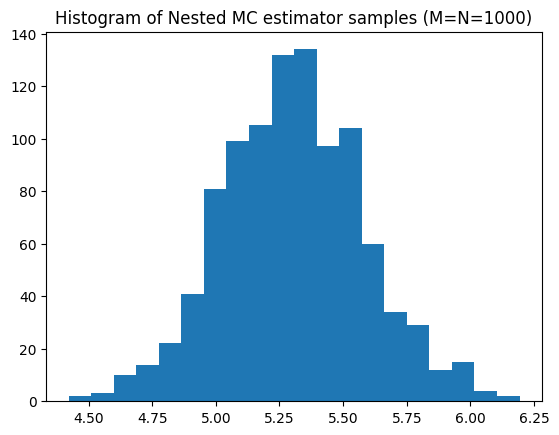

In [ ]:
M = 1000
N = 1000
k = 1000

# Generate k samples of the Nested MC estimator
I_MN = [NestedEstimator(t_1, t_2, K, S_0, sigma, M, N) for _ in range(k)]

# Estimate the RMSE
rmse = np.sqrt(np.mean([(benchmark_value - sample)**2 for sample in I_MN]))

print(f"RMSE: {rmse}")

# Plot the histogram of the k samples
plt.hist(I_MN, bins=20)
plt.title("Histogram of Nested MC estimator samples (M=N=1000)")
plt.show()

**Second case:** 

we will generate a sample of  $k = 1000 $  i.i.d. values of the estimator $I_{M,N}$ , choosing
$$M = N^2 = 1000$$

RMSE: 0.30936394076588813


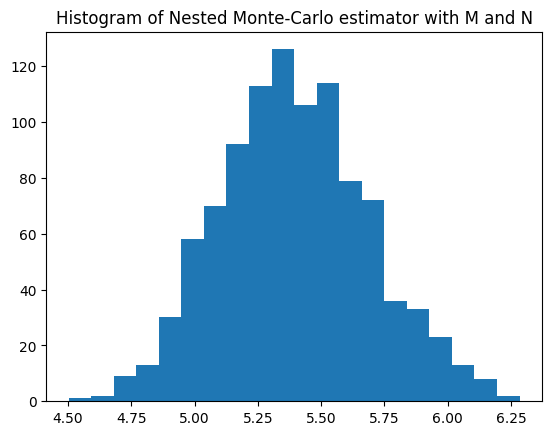

In [ ]:
M = 1000
N = int(np.sqrt(M))
k = 1000

# Generate k samples of the Nested MC estimator
I_MN = [NestedEstimator(t_1, t_2, K, S_0, sigma, M, N) for _ in range(k)]

# Estimate the RMSE
rmse = np.sqrt(np.mean([(benchmark_value - sample)**2 for sample in I_MN]))

print(f"RMSE: {rmse}")

# Plot the histogram of the k samples
plt.hist(I_MN,  bins=20)
plt.title(f"Histogram of Nested Monte-Carlo estimator with M and N")
plt.show()


We can conclude that even with both cases we got good results, we can notice that whenever we increase of M and N, it leads to a better accuracy. However, the computational complexity increases as well.

## Tasks:
Use a deep neural network to approximate the inner conditional expectation in order to compute  this same price. Compare its efficiency with the above Nested Monte Carlo. 

In this part of the project, we will be estimating $I$ as well but with a deep neural network. We start first by generating some data.

##Generating Data

We start by initializing our parameters with the number of generated values where we train 80% of this number.

In [ ]:
t_0 = 0
t_1 = 1
T = 2    
K = 100
sigma = 0.3

nb = 5000      # number of generated values
train_nb = int(0.8*nb)

Now we randomly generate values of $S_0$ from the uniform distribution do create a dataset for our NN to learn.

In [ ]:
S_0 = np.array(np.random.uniform(30, 300, nb), dtype='float32').reshape(nb, 1) # stock price as an array of nb random values uniformly distributed between 30 and 300.

Then we compute the put price for all the generated $S_0$ at time $t_0$ correspondingly. 

In [ ]:
price_at_zero = putPrice(t=0, S=S_0, T=t_2, K=K, sigma=sigma) #put price at t=0

And with the results below, we find the real values of the integral $I$, which we are going to set as a target values for our future NN. Unfortunately, even with GPU it takes quite long to calculate the integral values, so we were not able to construct a big dataset, that obviously influences our results in the future. 

In [ ]:
benchmark_value = []

for i in range(len(S_0)):
    def to_integrate(y, sigma = 0.3, S_0 = S_0[i], t_0 = 0, t_1 = 1, price_at_zero = price_at_zero[i]):
        
        S_t_1 = S_0 * np.exp(sigma*np.sqrt(t_1) * y - 0.5*sigma*sigma*t_1)
        
        loss_t_1 = putPrice(t=t_1, S=S_t_1, T=t_2, K=K, sigma=sigma) - price_at_zero

        positivePart = np.maximum(loss_t_1, 0.)

        density = np.exp(-0.5*y*y) / np.sqrt(2*np.pi)

        return positivePart * density

    benchmark_value.append(quad(to_integrate, a= -np.inf, b =np.inf)[0])

<ipython-input-7-33bdfd948258>:8: RuntimeWarning: divide by zero encountered in true_divide
  d = np.log(K/S) / sigmaSqrtDeltaT + sigmaSqrtDeltaT/2
<ipython-input-7-33bdfd948258>:8: RuntimeWarning: overflow encountered in true_divide
  d = np.log(K/S) / sigmaSqrtDeltaT + sigmaSqrtDeltaT/2
<ipython-input-15-e0a0a429a7d7>:16: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  benchmark_value.append(quad(to_integrate, a= -np.inf, b =np.inf)[0])
<ipython-input-15-e0a0a429a7d7>:16: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges

Now let us show the dataset we decided to work with, the fixed and changable values. 

As we have said, we generated Stock Prices from the uniform distribution, and then found the Put Prices. We fixed the values of $t_0$, $t_1$, maturity time $T$ and volatility. 

The logic under this was next: 

*   We do not have enough data to make a lot of parameters changable;
*   The Put price at $t_0, S_0$ is the value that is quite easy to find, and it is directly related to the explicit integral formula of $I$, that we took as a benchmark value; consequently we can expect the NN to catch the relevant trens and patterns and give us a nice output;
* Other values, that are present in the formula are hard to find without any additional information.






In [ ]:
import pandas as pd

df = pd.DataFrame(S_0)
df.columns = ['Stock Price']
df['t_0'] = t_0 * np.ones_like(S_0, dtype=float)
df['t_1'] = t_1 * np.ones_like(S_0, dtype=float)
df['T'] = T * np.ones_like(S_0, dtype=float)
df['Volatility'] = sigma * np.ones_like(S_0, dtype=float)
df['Put Price'] = putPrice(t=t_0, S=S_0, T=t_2, K=K, sigma=sigma)
df['I(target)'] = benchmark_value

df

,Stock Price,t_0,t_1,T,Volatility,Put Price,I(target)
0,106.145409,0.0,1.0,2.0,0.3,14.411290,4.895719
1,290.468475,0.0,1.0,2.0,0.3,0.136451,0.103866
2,277.238007,0.0,1.0,2.0,0.3,0.186684,0.139127
3,66.006439,0.0,1.0,2.0,0.3,36.939181,6.399679
4,194.915604,0.0,1.0,2.0,0.3,1.442513,0.876286
...,...,...,...,...,...,...,...
4995,40.642342,0.0,1.0,2.0,0.3,59.519256,4.756676
4996,90.711784,0.0,1.0,2.0,0.3,21.077840,5.841697
4997,226.752335,0.0,1.0,2.0,0.3,0.642265,0.430335
4998,78.189377,0.0,1.0,2.0,0.3,28.269845,6.343529


##Splitting the data into Train and test sets

In this part of the code, we assign to X and y the values of the put price and benchmark values from our dataframe and then we split the data into train and test sets.

In [ ]:
from sklearn.preprocessing import StandardScaler

X = df['Put Price']
y = df['I(target)']

X_train = X[:train_nb].values
y_train = y[:train_nb].values

X_test = X[train_nb:].values
y_test = y[train_nb:].values

## Import libraries

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend, Input
from keras.constraints import non_neg
from keras.callbacks import EarlyStopping
import tensorflow as tf

early_stopping=EarlyStopping(monitor='val_loss', patience=5)

## Set up, compile and fit the model

So the models that we decided to use had the following characteristics:


*   **Input**: Put Price
*   **Output**: $I$ values
*   **Loss function**: RMSE (since this is the one that we defined as a comparaison metric)
*   **Main layers of NN**: Dense()

In the following steps you will see the best model, that we could build, and its results, but firstly we want to present the logic behind each step in building it, and mention all uncountable trials, that unfortunately gave worse resunts. 

Here is the planthat we followed:


1.   Build a small NN (2-5 Dense layers, try different combinations of Dropout)
2.   See the results, compare after the trials, choose the best model and start to tune all the parameters (amount of the neurons, activation functions, lerning rate, Dropout rate etc)
3. After theese steps did not give the desirable results -> add more layers and repeat the steps 1. 2. and 3. until the results that will satisfy. 











We firstly define the loss function, that we will use for our NN:

In [ ]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

We create now our model which is a deep neural network with several hidden layers, each using the sigmoid activation function to introduce non-linearity. Dropout layers are added to reduce overfitting, and the final output layer predicts a single numerical value with a ReLU activation function. 

For more precision, the input layer is added with a shape of (1,), indicating a single input feature. Several dense layers with different activation functions (sigmoid) and different numbers of units (neurons) are added. The Dropout layers are added after some dense layers to prevent overfitting by randomly dropping a fraction of the input units during training. And the final layer is a dense layer with a single unit and the 'relu' activation function.
A LeakyReLU activation function is added after the final layer to introduce non-linearity and prevent the dying ReLU problem.

After creation of the model, we compile the model by specifying the optimizer, loss function, and optional metrics. The Adam optimizer is used with a learning rate of 0.00001 and the root_mean_squared_error function is set as the loss function. And then, we train the model for a specified number of epochs (500) with a batch size of 32. A validation split of 0.1 is used, which means 10% of the training data is used for validation during training.

Finally, we use the trained model  to make predictions on the test data X_test.

In [ ]:
import keras 
model = Sequential()
model.add(Input(shape=(1,)))
model.add(Dense(512,  activation='sigmoid')) 
model.add(Dropout(0.4))
model.add(Dense(512,  activation='sigmoid')) 
model.add(Dense(256,  activation='sigmoid')) 
model.add(Dropout(0.4))
model.add(Dense(256,  activation='sigmoid')) 
model.add(Dense(128,  activation='sigmoid')) 
model.add(Dropout(0.4))
model.add(Dense(128,  activation='sigmoid')) 
model.add(Dense(64,  activation='sigmoid')) 
model.add(Dropout(0.4))
model.add(Dense(64,  activation='sigmoid')) 
model.add(Dense(32,  activation='sigmoid')) 
model.add(Dropout(0.2))
model.add(Dense(32,  activation='sigmoid')) 
model.add(Dense(16,  activation='sigmoid')) 
model.add(Dropout(0.2))
model.add(Dense(16,  activation='sigmoid')) 
model.add(Dense(8,  activation='sigmoid')) 
opt = keras.optimizers.Adam(learning_rate=0.00001)


model.add(Dense(1 ,activation='relu'))
model.add(LeakyReLU())


model.compile(optimizer = opt, loss = root_mean_squared_error)
              
history = model.fit(X_train, y_train, batch_size=32, epochs=500, validation_split=0.1)
predictions=model.predict(X_test)

Epoch 1/500
113/113 [==============================] - 5s 6ms/step - loss: 2.7183 - val_loss: 2.7242
Epoch 2/500
113/113 [==============================] - 0s 4ms/step - loss: 2.7135 - val_loss: 2.7143
Epoch 3/500
113/113 [==============================] - 0s 4ms/step - loss: 2.7061 - val_loss: 2.7044
Epoch 4/500
113/113 [==============================] - 1s 4ms/step - loss: 2.6928 - val_loss: 2.6946
Epoch 5/500
113/113 [==============================] - 0s 4ms/step - loss: 2.6883 - val_loss: 2.6849
Epoch 6/500
113/113 [==============================] - 0s 4ms/step - loss: 2.6810 - val_loss: 2.6751
Epoch 7/500
113/113 [==============================] - 1s 5ms/step - loss: 2.6709 - val_loss: 2.6655
Epoch 8/500
113/113 [==============================] - 0s 4ms/step - loss: 2.6583 - val_loss: 2.6559
Epoch 9/500
113/113 [==============================] - 1s 5ms/step - loss: 2.6527 - val_loss: 2.6464
Epoch 10/500
113/113 [==============================] - 0s 4ms/step - loss: 2.6470 - val_lo

To evaluate the model, we use the mean squared error (MSE) between the predicted values and the true values y_test.

In [ ]:
mse = tf.keras.losses.mean_squared_error(y_test, predictions).numpy()
rmse = np.sqrt(np.mean(mse))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 2.2622094


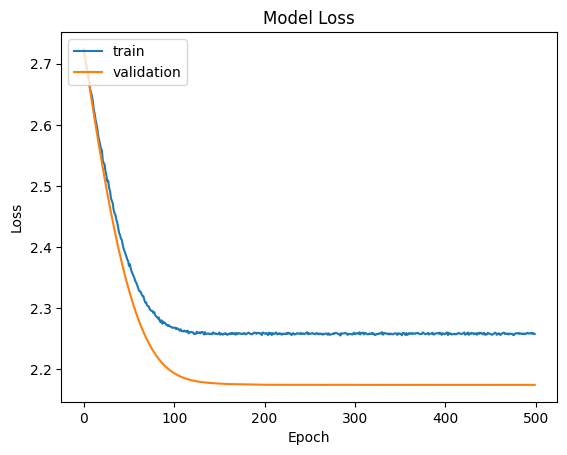

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','validation'],loc= 'upper left')
plt.show() 

As we can see, the NN here coul not beat the Monte Carlo method with its precision of RMSE and we think there might be some reasons: 


*   Not enough of data. As you cna see, the maximum amount of neurons we took in the first Dense layer is 512, because after taking more, the modeel was automatically capturing irrelevant patterns from the data and giving worse results. 
*   Quite complicated function restore from the amount of input values and input data. 



---



Nevertheless, we still think, that NN showed quite good results, and it potentially has a chance to beat MC if the issues described before are solved. 